If running on colab:

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
!ln -s "/gdrive/My Drive/ColabNotebooks/data" "/content/data"

Mounted at /gdrive


In [6]:
from data import mask_to_submission
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage import color
import os
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler, random_split
import albumentations as album
%matplotlib inline

from scripts.preprocessing import *
from scripts.evaluation import *

# Project Road Segmentation

For this choice of project task, we provide a set of satellite images acquired
from GoogleMaps. We also provide ground-truth images where each pixel is labeled
as road or background.

Your task is to train a classifier to segment roads in these images, i.e.
assigns a label `road=1, background=0` to each pixel.

Submission system environment setup:

1. The dataset is available from the
[AICrowd page](https://www.aicrowd.com/challenges/epfl-ml-road-segmentation).

2. Obtain the python notebook `segment_aerial_images.ipynb` from this github
folder, to see example code on how to extract the images as well as
corresponding labels of each pixel.

The notebook shows how to use `scikit learn` to generate features from each
pixel, and finally train a linear classifier to predict whether each pixel is
road or background. Or you can use your own code as well. Our example code here
also provides helper functions to visualize the images, labels and predictions.
In particular, the two functions `mask_to_submission.py` and
`submission_to_mask.py` help you to convert from the submission format to a
visualization, and vice versa.

3. As a more advanced approach, try `tf_aerial_images.py`, which demonstrates
the use of a basic convolutional neural network in TensorFlow for the same
prediction task.

Evaluation Metric:
 [F1 score](https://en.wikipedia.org/wiki/F1_score)


### Example Image

(400, 400, 3) (400, 400, 3)


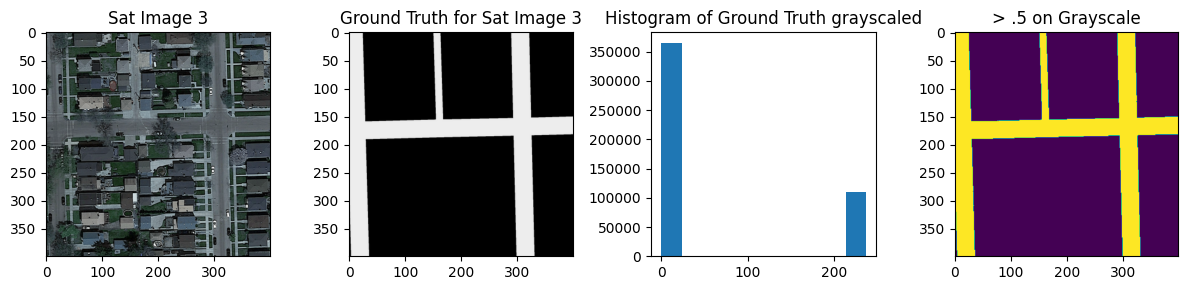

In [3]:
img_idx = 3
im = cv.imread(f'data/training/images/satImage_00{img_idx}.png')
im_gt = cv.imread(f'data/training/groundtruth/satImage_00{img_idx}.png')
im_gt_gs = np.where(color.rgb2gray(im_gt) > .5, 1, 0)

fig, ax = plt.subplots(1, 4, figsize = (12, 3))
ax[0].imshow(im)
ax[0].set_title(f"Sat Image {img_idx}")
ax[1].imshow(im_gt)
ax[1].set_title(f"Ground Truth for Sat Image {img_idx}")
ax[2].hist(im_gt.flatten(), bins = 10)
ax[2].set_title('Histogram of Ground Truth grayscaled')
ax[3].imshow(im_gt_gs)
ax[3].set_title('> .5 on Grayscale')

print(im.shape, im_gt.shape,)
plt.tight_layout()
plt.show()

##Table of contents

<font size = 3> The task is **semantic segmentation**, and in this particular case binary classification of road pixels. For images this means generating a 2d mask of binary values for 1: road and 0: other pixels. To solve this task our project will use the following methods and follow this plan as a road map to success:
> ### 0) Helper functions
> ### 1) Random classification
> ### 2) Dummy classifier
> ### 3) Image processing algorithm
> ### 4) Classic machine learning techniques with custom feature vectors
> > ##### i) Feature extraction
> > ##### ii) Linear Regression
> > ##### iii) Logistic Regression
> > ##### iv) Additional Method
> > ##### v) Model comparison and statistics
> ### 5) Convolutional Neural Networks
> >  #### i) Classic CNN. VGG13
> > #### ii) U-Net CNN. https://arxiv.org/pdf/1505.04597.pdf
> > #### iii) Competition Submission
> > #### iv) Data Augmentation
> > > ##### a) Data Augmentation (Rotating, Flipping, Crop & Resize, Gaussian Noise and other generated Corruptions)
> > > ##### b) Dataset complementation with Masachussetts or DeepGlobe
> > > ##### c) Model comparison
> > #### v) Favorite Model Variations
> ### 6) Transfer Learning

## 1) Random Classifier

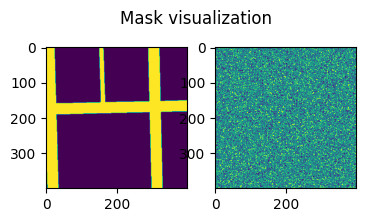

{'Accuracy': 0.4985625,
 'Precision': 0.2327914259691325,
 'Recall': 0.49891702542984734,
 'F1-score': 0.31745869702074087}

In [ ]:
#Fixed seed
np.random.seed(7)

def RandomClassifier(input_img):
    output_mask = (np.random.rand(input_img.shape[0],input_img.shape[1]) > 0.5) * 255
    return color.gray2rgb(output_mask)

#No need to generalize to the whole dataset, we simply calculate the accuracy for 1 image
predicted_mask = parse_mask_to_binary( RandomClassifier(im))

fig, ax = plt.subplots(1, 2, figsize = (4, 8))
ax[0].imshow(im_gt_gs)
ax[1].imshow(predicted_mask)
fig.suptitle("Mask visualization", y = 0.63)
plt.show()

metrics(y_pred = predicted_mask.flatten(), y = im_gt_gs.flatten())

So as hypothesized, the random classifier has an accuracy of ~50%, and this is the case of a single image from the training set where we luckily have a similar number of road/background pixels ratio = 1. This is a nice benchmark to understand the dataset and compare our models to, but nothing else.

## 2) Dummy Classifier

What is a dummy classifier in our case? Well, one could see it as an emperical statistical estimation of what a road pixel should look like and then classifying all pixels through this condition.

One of the most straight forward dummy classifiers we can make is to take a look at our image's color histograms and deduce an empiricala condition on this.

We have 3 different channels per image R, G, B. but since roads are mostly gray, we can take a look at at a computed hue or HSV channel or even just the grayscale channel

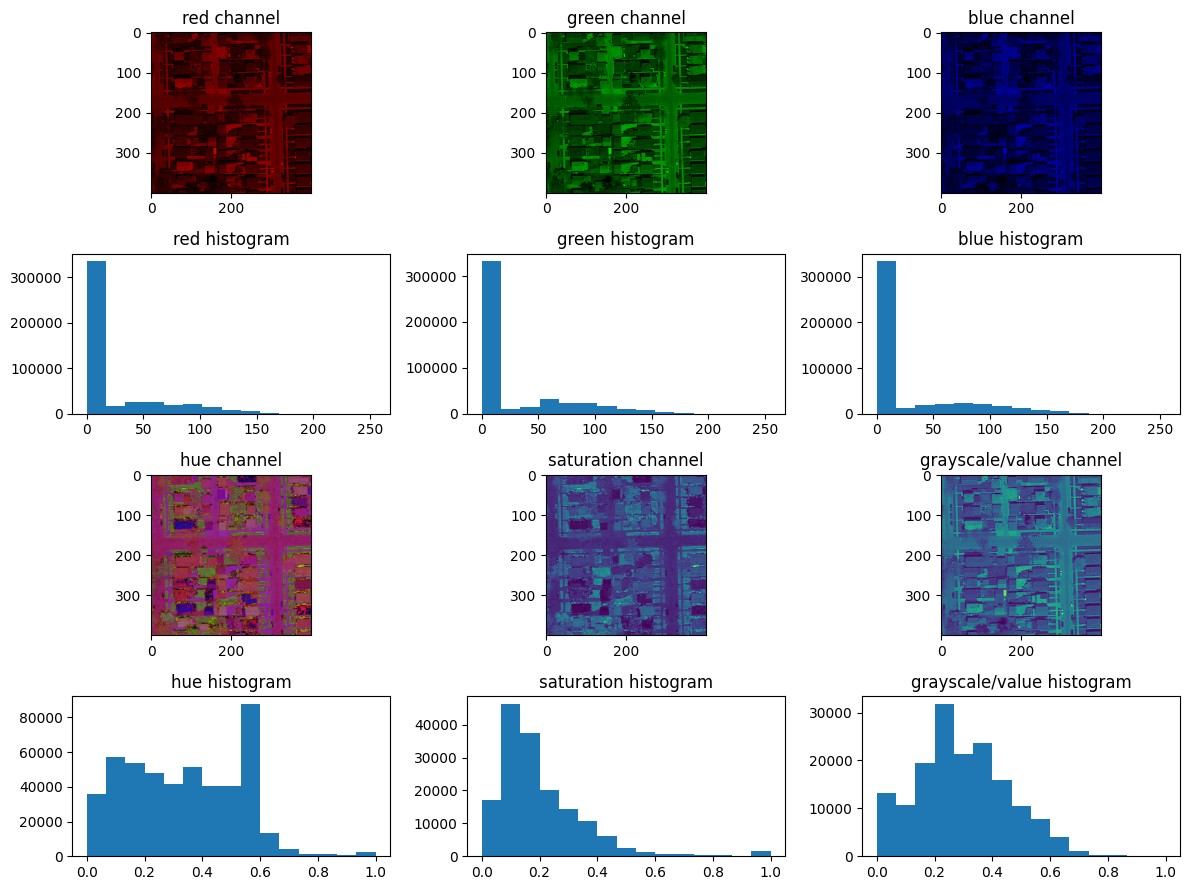

In [7]:
im_red_channel = im.copy()
im_red_channel[:, :, 1] = 0
im_red_channel[:, :, 2] = 0

im_green_channel = im.copy()
im_green_channel[:, :, 0] = 0
im_green_channel[:, :, 2] = 0

im_blue_channel = im.copy()
im_blue_channel[:, :, 0] = 0
im_blue_channel[:, :, 1] = 0

im_hsv = color.rgb2hsv(im)
im_hue_channel = im_hsv[:, :, 0]
im_saturation_channel = im_hsv[:, :, 1]

im_grayscale = color.rgb2gray(im)


channels = {"red": im_red_channel, "green": im_green_channel, "blue": im_blue_channel, "hue": im_hsv, "saturation": im_saturation_channel,
            "grayscale/value": im_grayscale}

fig, ax = plt.subplots(4, 3, figsize = (12, 9))
for kdx, key in enumerate(channels):
    ax[2*int(kdx/3), kdx%3].imshow(channels[key])
    ax[2*int(kdx/3), kdx%3].set_title(key + " channel")

    ax[2*int(kdx/3) + 1, kdx%3].hist(channels[key].flatten(), bins = 15)
    ax[2*int(kdx/3) + 1, kdx%3].set_title(key + " histogram")

plt.tight_layout()
plt.show()

What we can see is that there are no histogram peaks or bumps for our road pixel values and this is a clear challenge in our task, as the satellite images are taken from a bird's eye view, the house roof's are also gray and of very similar color to the roads, which makes it hard to discern valid barriers.
None the less in our HSV histograms, we seem to have a certain peak at around .15 for the saturation channel, lets see if this generalizes to the rest of the training set.


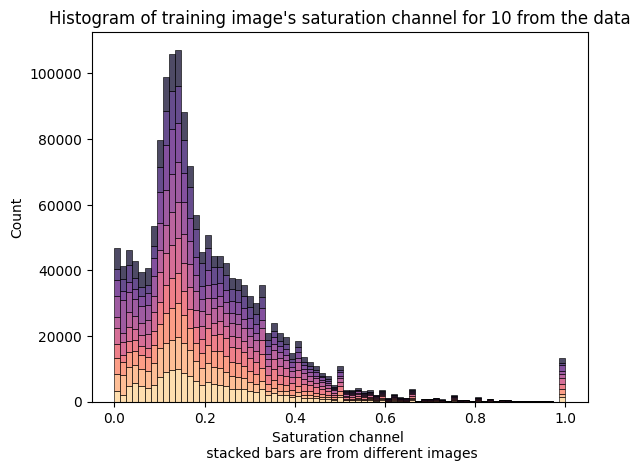

In [8]:
hue_images = []
n_images = 10 #Take n images as to not overload memory
TRAINING_DIR = "data/training/images/"
for root, dirs, files in sorted(os.walk(TRAINING_DIR)): training_images = sorted(files)

for img_name in training_images[:n_images]:
    img = cv.imread(TRAINING_DIR+img_name)
    hue_images.append(color.rgb2hsv(img)[:,:, 1].flatten()) #Extractng flattened hue pixel values

#hue_images = np.concatenate(hue_images)
sns.histplot(hue_images, bins = 75, palette = sns.color_palette("magma", n_colors=n_images), multiple='stack', legend=False)
plt.title(f"Histogram of training image's saturation channel for {n_images} from the data")
plt.xlabel("Saturation channel \n stacked bars are from different images")
plt.show()


So there seems to be a generalizable trend for our dummy classifier of a peak of values from 0.1 to 0.2 in saturation values, lets make the classifier and evaluate it's performance

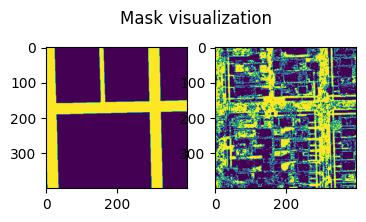

{'Accuracy': 0.67273,
 'Precision': 0.40043,
 'Recall': 0.61594,
 'F1-score': 0.48534}

In [10]:
def DummyClassifier(input_img):
    saturation_channel = color.rgb2hsv(input_img)[:, :, 1]
    output_mask = np.where((saturation_channel > 0.1) & (saturation_channel < 0.2), 1, 0)
    return output_mask

TRAINING_DIR = "data/training/"
for root, dirs, files in sorted(os.walk(TRAINING_DIR + 'images')): training_images = sorted(files)
n_images = 10 #Take n images as to not overload memory

sum_labels = [[], []]
for file_name in training_images[:n_images]:
    img = cv.imread(TRAINING_DIR+'images/'+file_name)

    groundtruth_mask = cv.imread(TRAINING_DIR+'groundtruth/'+file_name)
    predicted_mask = DummyClassifier(img)

    sum_labels[0].append(predicted_mask.flatten())
    sum_labels[1].append(parse_mask_to_binary(groundtruth_mask).flatten())

y_pred = np.concatenate(sum_labels[0])
y = np.concatenate(sum_labels[1])

predicted_mask = DummyClassifier(im)

fig, ax = plt.subplots(1, 2, figsize = (4, 8))
ax[0].imshow(im_gt_gs)
ax[1].imshow(predicted_mask)
fig.suptitle("Mask visualization", y = 0.63)
plt.show()

metrics(y_pred, y)

So these average metrics are already better scores than the random classifier which is nice.

## 3) Image processing algorithm

Having taken a look at the histograms for our dummy classifier, this got us thinking what other image properties and methods we could use. Before neural networks, semantic segmentation worked through smart region growing algorithms with similar pixels of interest. These are methods could work for our task too.

## 4) Classic machine learning techniques
#### i) Feature extraction
#### ii) Linear Regression
#### iii) Logistic Regression
#### iv) Decision Tree/SVM/Forest (don't know which one, Nearest neighbors?)

### i) Feature extraction

Images has always been a tricky task for machine learning techniques and thats mainly the image to feature translation task that isn't obvious. In normal linear regression, you input a feature vector of a sample and obtain an output whether that be a classification or regression value to vector. For linear regression you simple cant input a 2d image as an input for a plethora of reasons. The main one being ambiguous dimensions, but also the if the features are simply the pixel values as a flattened vector, we lose our contextual information of the pixel.

In the provided code, we have a feature generation method, based on our RGB channels by dividing our images in linear patches and then infering features from those patches. This is great as we can assume through data inspection that our roads have a minimum width and this saves us alot of computational time.

Here we will try a different avenue of pixel feature generation and perhaps quickly see that this is not viable. (limitations no shape/fourier descriptors)

##### Now we will create our training dataset of with just our patches and train our classifiers with this patch feature dataset

In [ ]:
TRAINING_DIR = "data/training/"
for root, dirs, files in sorted(os.walk(TRAINING_DIR + 'images')): training_filenames = sorted(files)

training_data = []
n_patches = 16*16
n_images = 10
for fdx, file in enumerate(training_filenames):

    #patch features
    img = cv.imread(TRAINING_DIR+'images/'+file)
    img_patches = img_to_patches(img, number_of_patches=n_patches)
    patches_features = np.array([patch_to_features(patch) for patch in img_patches])

    #patch labels
    groundtruth_mask = cv.imread(TRAINING_DIR+'groundtruth/'+file)
    mask_patches = img_to_patches(groundtruth_mask, number_of_patches=n_patches)
    mask_labels = np.array([groundtruth_patch_to_label(patch, foreground_threshold=.25) for patch in mask_patches])

    img_data = np.concatenate([patches_features, mask_labels.reshape(-1, 1)], axis = 1)
    if (fdx%10 == 0): print('img number:', fdx)
    training_data.append(img_data)

training_df = pd.DataFrame(np.concatenate(training_data))

print("final dataframe shape:", training_df.shape) #should be (n_images*n_patches, n_features + 1) #without gabor filters n_features = 12
training_df.to_csv('data/derivatives/training_data_custom.csv') #save for later use to not run spaghetti code again

img number: 0
img number: 10
img number: 20
img number: 30
img number: 40
img number: 50
img number: 60
img number: 70
img number: 80
img number: 90
final dataframe shape: (25600, 13)


In [ ]:
training_df = pd.read_csv('data/derivatives/training_data_custom.csv', index_col=0)

scaler = StandardScaler()
training_df.iloc[:, :-1] = scaler.fit_transform(training_df.iloc[:, :-1].values)
display(training_df.sample())

X, y = (training_df.iloc[:, :-1], training_df.iloc[:, -1])

,0,1,2,3,4,5,6,7,8,9,10,11,12
13831,-0.108991,0.441331,-0.111324,0.511829,-0.057698,0.708747,0.169322,0.712967,0.023806,0.54774,-0.080305,0.641335,1.0


So now we have extracted our features for our training data, we can start looking at our models and evaluating ***training and validation metrics*** for our models

One more note is that cross validation is great for fine tuning, however, we hypothesize that our best model will include CNNs, so we will content ourselves with estimating validation metrics on a train-validation split.

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.15)

### ii) Linear Regression

Good ol' linear regression. Let's see how well it does, for this part we'll be using sklearn's SGD Classifier to cycle through classic ML models that we saw for project 1.

Training patches average: {'Accuracy': 0.66742, 'Precision': 0.58856, 'Recall': 0.52438, 'F1-score': 0.55462} 

Validation patches average: {'Accuracy': 0.68307, 'Precision': 0.59214, 'Recall': 0.56203, 'F1-score': 0.5767} 

Predicted mask average (on "whole" training set): {'Accuracy': 0.7401060000000002, 'F1-score': 0.618784}


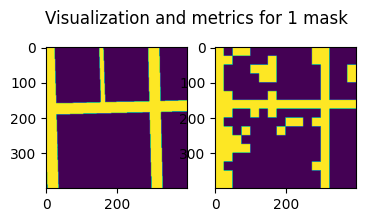

{'Accuracy': 0.875,
 'Precision': 0.67089,
 'Recall': 0.89831,
 'F1-score': 0.76812}

In [ ]:
n_epochs = 1000
linear_classifier = SGDClassifier(loss='squared_error', max_iter=n_epochs, tol=1e-12)
linear_classifier.fit(X_train.values,y_train.values)

training_predictions = linear_classifier.predict(X_train.values)
validation_predictions = linear_classifier.predict(X_validation.values) #difference between patch and mask accuracy

print('Training patches average:', metrics(training_predictions, y_train), '\n')
print('Validation patches average:', metrics(validation_predictions, y_validation), '\n')

print('Predicted mask average:', mask_predictions(scaler=scaler, model=linear_classifier, n_patches=n_patches,
        img_directory="data/training/images", gt_directory="data/training/groundtruth", dataset_size=10))

#visualization for a sample
visualize_predicition(im, im_gt_gs, scaler=scaler, model=linear_classifier,n_patches=n_patches)


Patch size has huge influence and results are quite variable, however we can clearly see a great improvement from our dummy classifier, the predicted mask average accuracy ~74% and F1-score ~61%.

### iii) Logistic Regression


Training patches average: {'Accuracy': 0.69991, 'Precision': 0.65891, 'Recall': 0.49773, 'F1-score': 0.56709} 

Validation patches average: {'Accuracy': 0.71589, 'Precision': 0.66552, 'Recall': 0.52339, 'F1-score': 0.58596} 

Predicted mask average (on "whole" training set): {'Accuracy': 0.7446010000000001, 'F1-score': 0.620268}


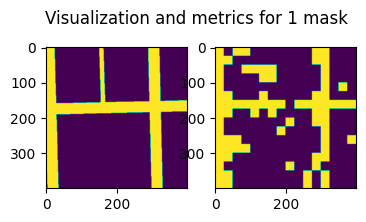

{'Accuracy': 0.84766,
 'Precision': 0.625,
 'Recall': 0.84746,
 'F1-score': 0.71942}

In [ ]:
n_epochs = 100000
logistic_regression= SGDClassifier(loss='log_loss', max_iter=n_epochs, tol=1e-12)
logistic_regression.fit(X_train.values,y_train.values)

training_predictions = logistic_regression.predict(X_train.values)
validation_predictions = logistic_regression.predict(X_validation.values)

print('Training patches average:', metrics(training_predictions, y_train), '\n')
print('Validation patches average:', metrics(validation_predictions, y_validation), '\n')

print('Predicted mask average:', mask_predictions(scaler=scaler, model=logistic_regression, n_patches=n_patches,
        img_directory="data/training/images", gt_directory="data/training/groundtruth", dataset_size=10))

visualize_predicition(im, im_gt_gs, scaler=scaler, model=logistic_regression,n_patches=n_patches)

Logistic regression outperforms linear regression on the patch accuracy and mask accuracy. To be expected.

### iv) Try one last model, ideas: Random forests, SVM, k-NN with cool distance metrics (cosine distance)

### v) Performance statistics & visualization
bar plot of performance recap of each model & accuracy depending on patch size

## 5) Convolutional Neural Networks

Well time to roll up our sleeves.
CNNs leverage convolutional layers to automatically and adaptively learn spatial hierarchies of features from the input data.
Convolution involves applying a set of filters (kernels) to the input image, sliding them across the image, and computing dot products at each location.
The result of the convolution operation is a set of feature maps. Each feature map represents the activation of a particular filter and highlights specific patterns or features present in our satellite images.

Instead of having an ansatz on deciding which filters we're going to use to generate feature vectors, we will learn the filters. cool beans

To custom design & test CNN architectures, we will use pytorch api and library.

>  #### i) Classic CNN. VGG13
> #### ii) U-Net CNN. https://arxiv.org/pdf/1505.04597.pdf
> #### iii) Competition Submission
> #### iv) Data Augmentation
> > ##### a) Data Augmentation (Rotating, Flipping, Crop & Resize, Gaussian Noise and other generated Corruptions)
> > ##### b) Dataset complementation with Masachussetts or DeepGlobe
> > ##### c) Model comparison
> #### v) Favorite Model Variations


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

### 0) Functions

In [2]:
from scripts.models import *
from scripts.training import *

### i) Classic CNN, VGG-13

The first type of CNNs we'll explore are the classic CNNs used for image classification. We will use their CNN backbone architecture to create nice features for our image. Our task, however, is image segmentation so to adapt the traditional CNN-backbone into a full connected network used for image classification, we will treat our image segmentation as patch-wise image classification.

We know that the Aircrowd submission takes 16x16 patches of our mask as a submission, so we will do the same for our patch-wise classification.

Finally, for the CNN-backbone, there are many well known examples: LeNet, AlexNet, VGG16, GoogLeNet and the ResNet architectures.
We will inspire ourselves off of the **VGG16** CNN architecture. Since image patches though are only 16x16, we will use a reduced architecture also known as VGG13. (For the 13 layers, 10 convolutional and 3 Fully-connected.

In [ ]:
#Create nice patch dataset
TRAINING_DIR = "data/training/"
for root, dirs, files in sorted(os.walk(TRAINING_DIR + 'images')): training_filenames = sorted(files)

training_patches, training_labels = ([], [])
patch_size = 16 #according to Aircrowd competition
for fdx, file in enumerate(training_filenames):

    #patch features
    img = cv.imread(TRAINING_DIR+'images/'+file)
    img_patches = img_to_patches_fixed(img, patch_size=patch_size)

    #patch labels
    groundtruth_mask = cv.imread(TRAINING_DIR+'groundtruth/'+file)
    mask_patches = img_to_patches_fixed(groundtruth_mask, patch_size=patch_size)
    #.25 threshold, per provided code
    mask_labels = np.array([groundtruth_patch_to_label(patch, foreground_threshold=.25) for patch in mask_patches])

    training_patches.append(img_patches)
    training_labels.append(mask_labels)
    if (fdx%20 == 0): print('img number:', fdx)

training_patches = np.concatenate(training_patches)
training_labels = np.concatenate(training_labels)
print("dataset shape:", training_patches.shape, "labels shape:" ,training_labels.shape)

np.save('data/derivatives/training_patches.npy', training_patches) #Save data to later not have to rerun this alot
np.save('data/derivatives/training_labels.npy', training_labels)

img number: 0
img number: 20
img number: 40
img number: 60
img number: 80
dataset shape: (62500, 16, 16, 3) labels shape: (62500,)


In [ ]:
training_patches = np.load('data/derivatives/training_patches.npy')
training_labels = np.load('data/derivatives/training_labels.npy')

config = {
    "device": DEVICE,
    "model": "VGG16",
    "patch_size": 16,
    "n_epochs": 50,
    "batch_size": 256,
    "optimizer": "AdamW",
    "loss_function": "CrossEntropy",
    "learning_rate": 1e-4,
    "prediction_transform": "PatchPred",
    "labels_transform": "identity",
    "scheduler": "CosineAnnealing",
    "test_size": 0.1
}
 
vgg = train_model(X=training_patches, y=training_labels, config=config)

X_train shape: (56250, 16, 16, 3) (56250,)
Epoch: 005 train loss = 0.463275 val loss = 0.499265 train accuracy = 0.8432 val accuracy = 0.8025 validation F1 0.6580
Epoch: 010 train loss = 0.423317 val loss = 0.485404 train accuracy = 0.8864 val accuracy = 0.8230 validation F1 0.7160
Epoch: 015 train loss = 0.401753 val loss = 0.492287 train accuracy = 0.9088 val accuracy = 0.8133 validation F1 0.7249
Epoch: 020 train loss = 0.386783 val loss = 0.482698 train accuracy = 0.9247 val accuracy = 0.8265 validation F1 0.7305
Epoch: 025 train loss = 0.377157 val loss = 0.485824 train accuracy = 0.9348 val accuracy = 0.8233 validation F1 0.7269
Epoch: 030 train loss = 0.369901 val loss = 0.489664 train accuracy = 0.9422 val accuracy = 0.8208 validation F1 0.7178
Epoch: 035 train loss = 0.363642 val loss = 0.492980 train accuracy = 0.9487 val accuracy = 0.8177 validation F1 0.6994
Epoch: 040 train loss = 0.364907 val loss = 0.494873 train accuracy = 0.9473 val accuracy = 0.8112 validation F1 0.71

Predicted mask average: {'Accuracy': 0.9572800000000001, 'F1-score': 0.9380269999999999}


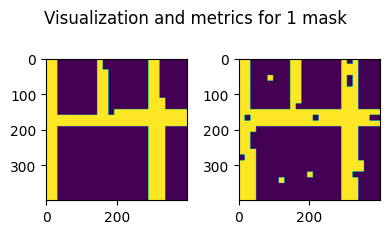

{'Accuracy': 0.9328,
 'Precision': 0.84615,
 'Recall': 0.94624,
 'F1-score': 0.8934}

In [ ]:
print('Predicted mask average:', mask_predictions_vgg(scaler=identity(), model=vgg, n_patches=25*25, img_directory='data/training/images',
                                                  gt_directory='data/training/groundtruth', dataset_size=10))
visualize_predicition_vgg(img=im, gt=im_gt_gs, scaler=identity(), model=vgg, n_patches=25*25)

89% F1-score on our whole training set and we only trained for 85% of the set. Convolutional neural networks are clearly the way to go. The reason the groundtruth looks different here, is that opted to compare the groundtruth that will be used in the AIcrowd competiton. This groundtruth is patched for a patch size of 16 and considered a road labeled patch if the patch has 25% road pixels

### ii) **U-Net**

Other CNNs have also been made that directly output a mask, and it isn't black magic, these architectures were made famous by the U-Net architecture. Lets try to make our own U-Net.

In [ ]:
#Create nice image dataset
TRAINING_DIR = "data/training/"
for root, dirs, files in sorted(os.walk(TRAINING_DIR + 'images')): training_filenames = sorted(files)

training_images, training_image_labels = ([], [])
for fdx, file in enumerate(training_filenames):

    img = cv.imread(TRAINING_DIR+'images/'+file)

    groundtruth_mask = cv.imread(TRAINING_DIR+'groundtruth/'+file)
    groundtruth_mask_binary = parse_mask_to_binary(groundtruth_mask)[:,:,None]

    training_images.append(img)
    training_image_labels.append(groundtruth_mask_binary)
    if (fdx%20 == 0): print('img number:', fdx)


training_images = np.array(training_images)
training_image_labels = np.array(training_image_labels)
print("dataset shape:", training_images.shape, "labels shape:" ,training_image_labels.shape)

np.save('data/derivatives/training_imgs.npy', training_images) #Save data to later not have to rerun this alot
np.save('data/derivatives/training_imgs_labels.npy', training_image_labels)

img number: 0
img number: 20
img number: 40
img number: 60
img number: 80
dataset shape: (100, 400, 400, 3) labels shape: (100, 400, 400, 1)


In [ ]:
training_imgs = np.load('data/derivatives/training_imgs.npy')
training_labels = np.load('data/derivatives/training_imgs_labels.npy')

unet_config = {
    "model": "U-Net",
    "patch_size": 16,
    "n_epochs": 50,
    "batch_size": 10,
    "optimizer": "AdamW",
    "loss_function": "BCELoss",
    "learning_rate": 1e-4,
    "prediction_transform": "identity_detach",
    "labels_transform": "unet_reshape",
    "scheduler": "CosineAnnealing",
    "device": DEVICE,
    "test_size": 0.1
}

unet = train_model(X=training_imgs, y=training_labels, config=unet_config)

X_train shape: (90, 400, 400, 3) (90, 400, 400, 1)
Epoch: 005 train loss = 0.463895 val loss = 0.415064 train accuracy = 0.4895 val accuracy = 0.5836 validation F1 0.7371
Epoch: 010 train loss = 0.363881 val loss = 0.383305 train accuracy = 0.5142 val accuracy = 0.5490 validation F1 0.7088
Epoch: 015 train loss = 0.324740 val loss = 0.361309 train accuracy = 0.5237 val accuracy = 0.5804 validation F1 0.7345
Epoch: 020 train loss = 0.304778 val loss = 0.333745 train accuracy = 0.5475 val accuracy = 0.6323 validation F1 0.7747
Epoch: 025 train loss = 0.273515 val loss = 0.341483 train accuracy = 0.5544 val accuracy = 0.5901 validation F1 0.7422
Epoch: 030 train loss = 0.248939 val loss = 0.310421 train accuracy = 0.5678 val accuracy = 0.6293 validation F1 0.7724
Epoch: 035 train loss = 0.231132 val loss = 0.302303 train accuracy = 0.5813 val accuracy = 0.6620 validation F1 0.7966
Epoch: 040 train loss = 0.214999 val loss = 0.291363 train accuracy = 0.5966 val accuracy = 0.6654 validation

Predicted mask average: {'Accuracy': 0.9726973, 'F1-score': 0.9361169999999995}


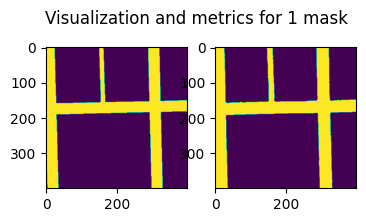

{'Accuracy': 0.97814, 'Precision': 0.91449, 'Recall': 1.0, 'F1-score': 0.95533}

In [ ]:
print('Predicted mask average:', mask_predictions_unet(model=unet, img_directory='data/training/images',
                                                  gt_directory='data/training/groundtruth'))
visualize_predicition_unet(img=im, gt=im_gt_gs, model=unet)

### iii) Competition Submission

In [ ]:
def test_masks(test_directory, model, visualize_number=6):

  test_filepaths = []
  for root, dirs, files in sorted(os.walk(test_directory))[1:]: test_filepaths.append(root+'/'+files[0])

  output_masks = [] #Here we go baby
  output_masks_filenames = []
  for fdx, file in enumerate(sorted(test_filepaths)):

    test_img = cv.imread(file)
    test_img = torch.tensor(test_img[:,:,:,None].T, dtype=torch.float32).to(device=DEVICE)

    mask = np.where(identity_detach(model(test_img)) > 0.5, 1, 0)[0][0]

    print(f"data/test_masks/{file.split('/')[-1]}")
    output_filename = f"data/test_masks/{file.split('/')[-1]}"
    output_masks_filenames.append(output_filename)
    cv.imwrite(output_filename, 255*mask.T)

    output_masks.append(mask.T)

  test_ids = [3, 10, 20] #np.random.choice(len(output_masks), size = visualize_number)
  fig, ax = plt.subplots(visualize_number, 2, figsize = (visualize_number*3, 6))

  for i in range(visualize_number):
    test_img = cv.imread(test_filepaths[test_ids[i]])
    ax[i, 0].imshow(test_img)
    ax[i, 1].imshow(output_masks[test_ids[i]])

  plt.show()
  return output_masks, output_masks_filenames

In [ ]:
test_directory = "data/test_set_images/"
predicted_test_masks, mask_filenames = test_masks(test_directory, model = unet,
                                                  visualize_number=3)

In [ ]:
mask_to_submission.masks_to_submission("data/sub002.csv", *mask_filenames)

### iv) Data Augmentation

> ##### a) Data Augmentation (Rotating, Flipping, Crop & Resize, Gaussian Noise and other generated Corruptions)
> ##### b) Dataset complementation with Masachussetts or DeepGlobe

#### a) Data Augmentation (Rotating, Flipping, Crop & Resize, Gaussian Noise and other generated Corruptions)

For this next part, we will perform data augmentation which are random changes to the images and masks of our training dataset to generate "new" images for our model to improve. For this we will be using a dataset class from torch and the albumentations library to generate these augmented images

In [ ]:
class RoadSegDataset(torch.utils.data.Dataset):

    """Read/load images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        #print("getting_item", i)
        image = cv.imread(self.image_paths[i]).astype('float32')
        mask = cv.imread(self.mask_paths[i]).astype('float32')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.image_paths)


def unet_rlabels(y):
  return y.type(torch.float32)

def numpy_and_binarize(x):
    return np.where(x.detach().cpu().numpy() > 0.5, 1, 0)

def split_data(dataset, ratio = 0.9):
  total_size = len(dataset)
  train_size = int(ratio * total_size)
  val_size = total_size - train_size
  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
  return train_dataset, val_dataset

In [ ]:
def train_model_augmented(x_directory, y_directory, config, use_model=None):

  dataset = RoadSegDataset(x_directory, y_directory, preprocessing = config['preprocessing'], augmentation = config['augmentation'] )
  train_dataset, validation_dataset = split_data(dataset, ratio = config['train_size'])
  train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=torch.cuda.is_available(),
                              drop_last = False, num_workers = 2)
  validation_loader = DataLoader(validation_dataset, batch_size=config['batch_size'])
  print("Loaded Augmented Dataset Class")

  n_epochs = config['n_epochs']

  device = config['device']
  model_dict = {"VGG16": VGG13, "U-Net": UNET}
  optimizer_dict = {"AdamW": optim.AdamW}
  loss_function_dict = {"CrossEntropy": nn.CrossEntropyLoss, "BCELoss": nn.BCELoss}
  scheduler_dict  = {'CosineAnnealing': torch.optim.lr_scheduler.CosineAnnealingLR}
  scheduler_kwargs_dict = {'CosineAnnealing': dict(T_max = n_epochs*len(train_loader.dataset))}

  prediction_transform_dict = {"PatchPred": PatchPred, "identity": identity_func, "identity_detach": identity_detach,
                               "numpy_and_binarize": numpy_and_binarize}
  labels_transform_dict = {"unet_reshape": unet_rlabels, "identity": identity_func}


  model = model_dict[config['model']]().to(device=device) #Get model
  if (use_model is not None):
    model = use_model
  optimizer = optimizer_dict[config['optimizer']](model.parameters(), lr = config['learning_rate']) #Get optimizer
  criterion = loss_function_dict[config['loss_function']]() #Get loss function

  scheduler = scheduler_dict[config['scheduler']](optimizer, **scheduler_kwargs_dict[config['scheduler']])

  prediction_transform = prediction_transform_dict[config['prediction_transform']]
  labels_transform = labels_transform_dict[config['labels_transform']]

  metrics_dict = {"training": [], "validation": []}
  print("Starting Epochs")
  for epoch in range(n_epochs):

        #Model training
        model.train()
        train_metrics = {'Accuracy': 0, 'F1-score': 0}
        total_train_loss = 0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device=device) # inputs: torch.Size([batch, C, 400, 400])
            labels = labels.to(device=device) # labels: torch.Size([batch, C, 400, 400])

            optimizer.zero_grad()
            prediction = model(inputs) # [B, C=1, H, W]
            labels = labels_transform(labels) # Binarize + [B, C=1, H, W]

            #print(type(prediction), type(labels))
            loss = criterion(prediction, labels)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

            prediction_class = prediction_transform(prediction) # Binarize
            labels = np.array(labels.detach().cpu().numpy())

            batch_metrics = metrics(prediction_class.flatten(), labels.flatten())
            train_metrics['Accuracy'] += batch_metrics['Accuracy']
            train_metrics['F1-score'] += batch_metrics['F1-score']

        train_metrics['Accuracy'] /= len(train_loader)
        train_metrics['F1-score'] /= len(train_loader)
        average_train_loss = total_train_loss/len(train_loader)

        if (epoch + 1) % 1 == 0:
            model.eval()
            validation_metrics = {'Accuracy': 0, 'F1-score': 0}
            total_validation_loss = 0
            for validation_inputs, validation_labels in validation_loader:
                validation_inputs, validation_labels = (validation_inputs.to(device=device), validation_labels.to(device=device))
                with torch.no_grad():
                    prediction = model(validation_inputs)
                    validation_labels = labels_transform(validation_labels)

                    validation_loss = criterion(prediction, validation_labels)
                    total_validation_loss += validation_loss.item()

                    prediction_class = prediction_transform(prediction)
                    validation_labels = np.array(validation_labels.detach().cpu().numpy())

                    batch_metrics = metrics(prediction_class.flatten(), validation_labels.flatten())
                    validation_metrics['Accuracy'] += batch_metrics['Accuracy']
                    validation_metrics['F1-score'] += batch_metrics['F1-score']

            validation_metrics['Accuracy'] /= len(validation_loader)
            validation_metrics['F1-score'] /= len(validation_loader)
            average_validation_loss = total_validation_loss/len(validation_loader)

            metrics_dict["training"].append(train_metrics)
            metrics_dict["validation"].append(validation_metrics)
            print('Epoch:', '%03d' % (epoch + 1), 'train loss =', '{:.6f}'.format(average_train_loss),
                   'val loss =', '{:.6f}'.format(average_validation_loss),'train accuracy =','{:.4f}'.format(train_metrics['Accuracy']),
                     'val accuracy =','{:.4f}'.format(validation_metrics['Accuracy']), 'validation F1', '{:.4f}'.format(validation_metrics['F1-score']))

  return model, metrics_dict

In [ ]:
def unet_preprocess_data(image, mask):

    # Perform any necessary preprocessing for U-net model:
    # Permute dimensions from HWC to CHW, binarize and reduce number of channels

    image = image.transpose(2, 0, 1)

    mask = mask.transpose(2, 0, 1)
    mask = np.where(mask == 0, 0, 1)
    mask = mask[0:1, :, :] #take one channel

    return {'image': image, 'mask': mask}

def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=400, width=400, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
        album.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.05),
        #album.RGBShift(r_shift_limit=15,g_shift_limit=15, b_shift_limit=15, p=0.5),
        album.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=0.1),
        ]
    return album.Compose(train_transform)

In [ ]:
## Re-running U-Net
unet_config_augmented = {
    "model": "U-Net",
    "preprocessing": unet_preprocess_data,
    "augmentation": get_training_augmentation(),
    "patch_size": 16,
    "n_epochs": 400,
    "batch_size": 10,
    "optimizer": "AdamW",
    "loss_function": "BCELoss",
    "learning_rate": .75*1e-4,
    "prediction_transform": "numpy_and_binarize",
    "labels_transform": "unet_reshape",
    "scheduler": "CosineAnnealing",
    "device": DEVICE,
    "train_size": .9
}

x_directory, y_directory = ("data/training/images/", "data/training/groundtruth")
unet_augmented, metrics_per_epoch = train_model_augmented(x_directory, y_directory, unet_config_augmented)

Loaded Augmented Dataset Class
Starting Epochs
Epoch: 001 train loss = 0.792735 val loss = 0.709538 train accuracy = 0.3464 val accuracy = 0.3819 validation F1 0.4279
Epoch: 002 train loss = 0.729778 val loss = 0.730639 train accuracy = 0.4630 val accuracy = 0.3573 validation F1 0.4087
Epoch: 003 train loss = 0.664388 val loss = 0.821921 train accuracy = 0.6204 val accuracy = 0.4021 validation F1 0.3602
Epoch: 004 train loss = 0.619011 val loss = 0.650741 train accuracy = 0.7030 val accuracy = 0.6451 validation F1 0.4500
Epoch: 005 train loss = 0.584380 val loss = 0.631144 train accuracy = 0.7579 val accuracy = 0.6728 validation F1 0.4716
Epoch: 006 train loss = 0.561264 val loss = 0.614129 train accuracy = 0.7889 val accuracy = 0.7038 validation F1 0.4679
Epoch: 007 train loss = 0.547525 val loss = 0.560535 train accuracy = 0.7862 val accuracy = 0.7827 validation F1 0.5936
Epoch: 008 train loss = 0.528461 val loss = 0.533440 train accuracy = 0.7966 val accuracy = 0.8053 validation F1 

Predicted mask average: {'Accuracy': 0.9515328, 'F1-score': 0.8765394000000001}


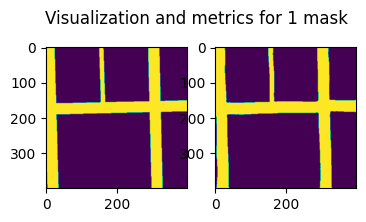

{'Accuracy': 0.97868,
 'Precision': 0.94138,
 'Recall': 0.96914,
 'F1-score': 0.95506}

In [ ]:
print('Predicted mask average:', mask_predictions_unet(model=unet_augmented, img_directory='data/training/images',
                                                  gt_directory='data/training/groundtruth'))
visualize_predicition_unet(img=im, gt=im_gt_gs, model=unet_augmented)

data/test_masks/test_1.png
data/test_masks/test_10.png
data/test_masks/test_11.png
data/test_masks/test_12.png
data/test_masks/test_13.png
data/test_masks/test_14.png
data/test_masks/test_15.png
data/test_masks/test_16.png
data/test_masks/test_17.png
data/test_masks/test_18.png
data/test_masks/test_19.png
data/test_masks/test_2.png
data/test_masks/test_20.png
data/test_masks/test_21.png
data/test_masks/test_22.png
data/test_masks/test_23.png
data/test_masks/test_24.png
data/test_masks/test_25.png
data/test_masks/test_26.png
data/test_masks/test_27.png
data/test_masks/test_28.png
data/test_masks/test_29.png
data/test_masks/test_3.png
data/test_masks/test_30.png
data/test_masks/test_31.png
data/test_masks/test_32.png
data/test_masks/test_33.png
data/test_masks/test_34.png
data/test_masks/test_35.png
data/test_masks/test_36.png
data/test_masks/test_37.png
data/test_masks/test_38.png
data/test_masks/test_39.png
data/test_masks/test_4.png
data/test_masks/test_40.png
data/test_masks/test_41.

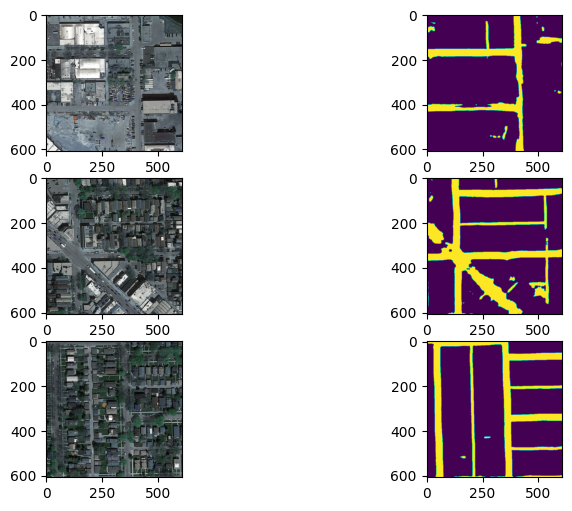

In [ ]:
test_directory = "data/test_set_images/"
predicted_test_masks, mask_filenames = test_masks(test_directory, model = unet_augmented,
                                                  visualize_number=3)

In [ ]:
mask_to_submission.masks_to_submission("data/sub003.csv", *mask_filenames)

So after running for 400 epochs, which took a while we got some pretty nice results, which on december 6th got us a 8th place spot in the competition. So the data augmentation and the long number of epochs worked :)

### Dataset combining with Masachussets dataset

### v) Favorite Model Variations

## Transfer Learning